#### Libraries

In [1]:
import copy, time
import random
import pdb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [2]:
from IPython import display
matplotlib.rcParams['figure.figsize'] = [26,8]

#### Generic Utils 

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value. 
       Also stores a rolling average of size roll_len."""
    def __init__(self, roll_len=100):
        self.reset()
        self.roll_len = roll_len
        self.roll = []

    def reset(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0; self.roll = []; self.roll_avg = 0

    def update(self, val, n=1):
        self.val = val; self.sum += val * n; self.count += n
        self.avg = self.sum / self.count
        self.roll = (self.roll + [val] * n)[-self.roll_len:]
        self.roll_avg = sum(self.roll) / len(self.roll)
        
def check(val, msg):
    '''Checks whether val is nan or inf and prints msg if True'''
    if (val * 0 != 0): print(msg); pdb.set_trace()
        
def to_numpy(t):
    '''PyTorch tensor to numpy array'''
    return t.detach().to('cpu').numpy()

#### Model

In [4]:
class FlatNet(nn.Module):
    def __init__(self, layers):
        super(FlatNet, self).__init__()
        self.layers = layers
        self.W_ids = [] # will hold indices of weights
        self.B_ids = [] # will hold incides of biases
        
        # Count total number of parameters and split into weights, biases
        ptr = 0 # current parameter
        for i in range(len(layers)-1):
            w_size = layers[i] * layers[i+1]
            b_size = layers[i+1]
            self.W_ids.append([ptr, ptr + w_size])
            self.B_ids.append([ptr + w_size, ptr + w_size + b_size])
            ptr += w_size + b_size
        self.N = ptr # total number of parameters    
        
        # Create and initialize parameters
        self.lambdas = nn.Parameter(torch.zeros(2 * self.N))
        self.lambdas.data[:self.N].fill_(0.0) # means
        self.lambdas.data[self.N:].fill_(0.4) # log standard deviations
        
    def get_means(self):
        return self.lambdas[:self.N]

    def get_stdvs(self):
        return F.softplus(model.lambdas[self.N:])

    def forward(self, x, sample):
        '''Unroll network and forward pass'''
        dim = 1
        for i in range(len(self.W_ids)):
            w = sample[self.W_ids[i][0]:self.W_ids[i][1]].reshape(dim, -1)
            b = sample[self.B_ids[i][0]:self.B_ids[i][1]].reshape(1,-1)
            dim = w.shape[1]
            
            x = x @ w + b
            x = torch.exp(-x*x) if i != len(self.W_ids)-1 else x
            
        return x

In [12]:
def BBB(x, y, model, optimizer, num_samples=1, epochs=int(1e5), seed=None, print_every=500):
    '''Performs black-box variational inference'''
    torch.manual_seed(seed if seed else random.randint(0,1000))
        
    # Track ELBO statistics
    elbo_meter = AverageMeter(100)
    elbo_hist = []
    
    # Prior
    p_dist = Normal(torch.zeros(model.N), 3.16 * torch.ones(model.N)) 
    
    for ix_e in range(epochs):
        gradients = torch.zeros_like(model.lambdas.data)
        for ix_s in range(num_samples):
            
            # Distributions
            q_dist = Normal(model.get_means(), model.get_stdvs())

            # Sample weights
            sample = q_dist.rsample()
                        
            # Likelihood
            y_hat = model.forward(x, sample)
            log_l = Normal(y_hat.squeeze(), 0.1 * torch.ones(6)).log_prob(y.squeeze()).sum()
            
            # Regularization
            log_p = p_dist.log_prob(sample).sum()
            log_q = q_dist.log_prob(sample).sum()
            
            # ELBO = log likelihood + log p - log q
            elbo = (log_l + log_p - log_q).squeeze()
            loss = - elbo / num_samples
            
            # Store gradients
            optimizer.zero_grad()
            loss.backward()
            gradients += model.lambdas.grad.data
            
            # Update ELBO statistics
            elbo_meter.update(elbo.item())
            elbo_hist.append(elbo.item())
        
        # Step gradient
        optimizer.step()

        # Print statistics
        if print_every > 0 and ix_e % print_every == 10: 
            print('{:5d} | ELBO {:6.0f} | Rolling: {:6.0f}'.format(
                ix_e, elbo_meter.avg, elbo_meter.roll_avg))

    return model, elbo_meter.roll_avg, elbo_hist

In [13]:
# Data and prediction range
X = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1)
Y = - X*X*X*X + 3*X*X + 1
X_range = torch.arange(-5,5,0.05).reshape(-1,1)

# Model and optimization with many random restarts
best_elbo = -1000
best_hist = None
best_model = None
random_restarts = 20
for _ in range(random_restarts):
    model = FlatNet([1,10,1])
    lr = 1e-3 # (torch.randn(1)*3e-5 + 1e-4).item() # random learning rate
    print('Learning rate: ', lr)
    optimizer = torch.optim.SGD([model.lambdas], lr=lr)
    model, elbo, hist = BBB(X, Y, model, optimizer, num_samples=5, print_every=4000, epochs=int(1e5))
    display.clear_output()
    if elbo > best_elbo:
        best_elbo = elbo
        best_hist = hist
        best_model = model
        print('---> Model with new best ELBO (lr={:.3f}): {:.2f}'.format(lr, best_elbo))
    else:
        print('     Model with ELBO (lr={:.2f},best={:.2f}): {:.2f}'.format(lr, best_elbo, elbo))

Learning rate:  0.001
   10 | ELBO  -2595 | Rolling:  -2595
 4010 | ELBO   -471 | Rolling:   -178
 8010 | ELBO   -291 | Rolling:    -98
12010 | ELBO   -225 | Rolling:    -91


KeyboardInterrupt: 

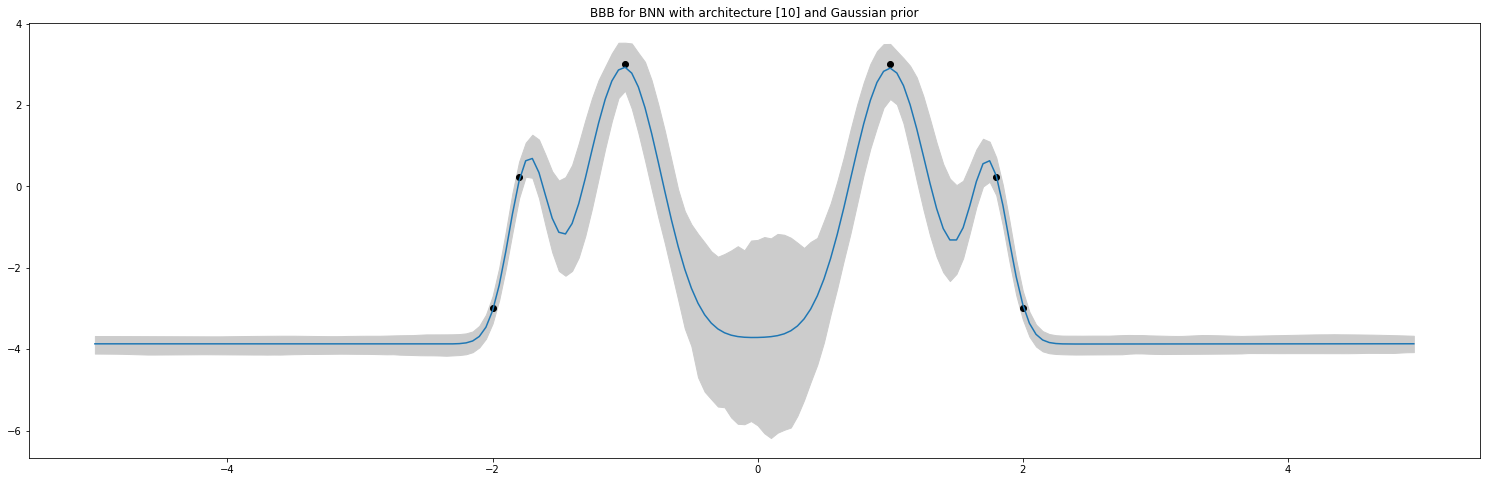

In [14]:
# Sample from distribution over networks
model = best_model if best_model else model
preds = [model(X_range, Normal(model.get_means(), model.get_stdvs()).sample()) for _ in range(1000)]
preds = np.concatenate(preds, axis=1)
bounds = (np.sort(preds, axis=1)[:, 5], np.sort(preds, axis=1)[:,-5])
mean = np.mean(preds, axis=1)

# Plot
plt.gca().set_title('BBB for BNN with architecture [10] and Gaussian prior')
plt.gca().fill_between(X_range.reshape(-1), bounds[1], bounds[0], color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')
plt.plot(to_numpy(X_range), mean)
plt.show() # plt.axis([-5,5,-8,8])

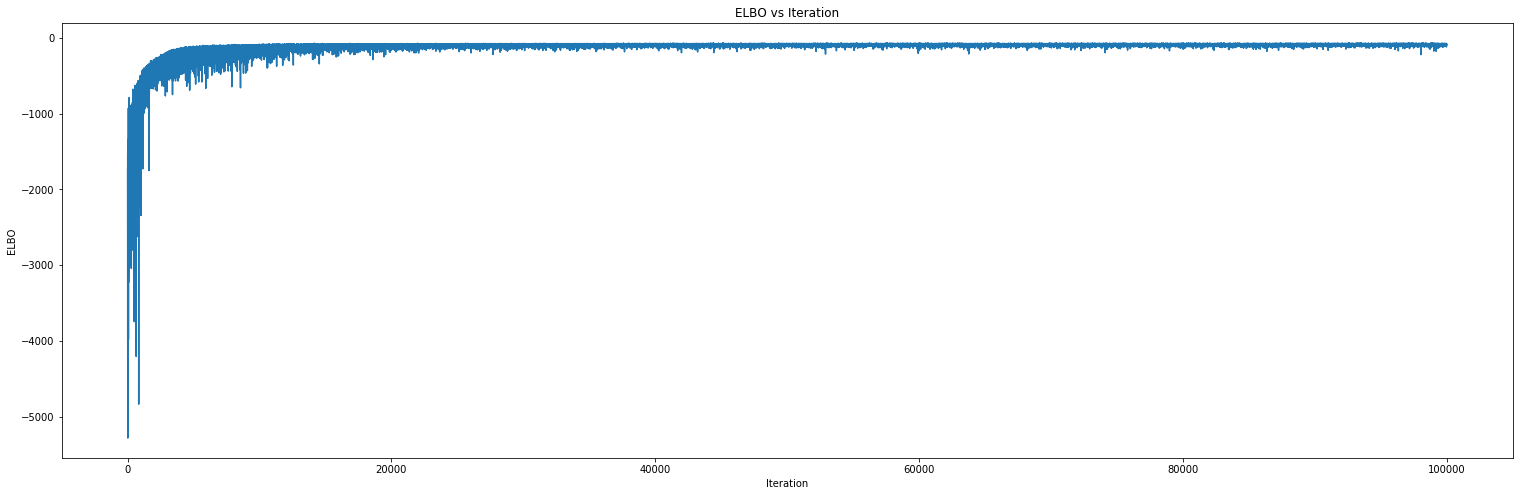

In [53]:
# Plot the ELBO
plt.title('ELBO vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.plot(best_hist)

In [83]:
# Calculate means and standard deviations of gradient updates
gs = []
for m in range(100):
    model = FlatNet([1,10,1])
    optimizer = torch.optim.SGD([model.lambdas], lr=1e-4)
    model, elbo, hist = BBB(X, Y, model, optimizer, print_every=-1, num_samples=100, epochs=int(1))
    gs.append(model.lambdas.grad)
gs = torch.stack(gs, dim=1)
for w in [1,5,7,15,21,30]:
    print('{:+5.4f} | {:+5.4f}'.format(gs[w].mean().item(), gs[w].std().item()))

+0.2423 | +5.6608
+0.6297 | +5.2286
-0.6628 | +4.7155
-0.3765 | +4.0678
-1.7970 | +4.6753
-1.9769 | +9.6733


In [ ]:
# # layers = [1,10,10,1]
# total = 0
# ws = []
# bs = []
# ptr = 0
# for i in range(len(layers)-1):
#     ws.append([ptr, ptr + layers[i] * layers[i+1]])
#     ptr = ptr + layers[i] * layers[i+1]
#     bs.append([ptr, ptr + layers[i+1]])
#     ptr = ptr + layers[i+1]
# #     total += layers[i] * layers[i+1] + 1 * layers[i+1]
# print(ptr)
# # for w, b in zip(ws, bs):
# #     print('W: ', w, ' | B: ', b)
# #     print()
# # print('Total: ', total)

In [64]:
# class SingleLayerNet(nn.Module):
#     def __init__(self, h):
#         super(SingleLayerNet, self).__init__()
#         self.h = h

#         # First 31 are means, last 31 are log_stds
#         self.lambdas = nn.Parameter(torch.zeros(62))
#         self.lambdas.data[:31].fill_(0.0)
#         self.lambdas.data[31:].fill_(0.5)
        
#     def forward(self, x, sample):
        
#         # Unroll sample weights
#         w1 = sample[  :10].reshape(1,10)
#         b1 = sample[10:20].reshape(1,10)
#         w2 = sample[20:30].reshape(10,1)
#         b2 = sample[30:31].reshape( 1,1)
        
#         # Forward pass
#         x = x @ w1 + b1                  # (x-w1) / b1 
#         x = torch.exp(-x*x)              # torch.exp(-(x-w1)*(x-w1) / (b1*b1)) 
#         x = x @ w2 + b2
#         return x